In [ ]:
#libraries
#----------------------------------------------------------------------------
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os
import time
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
#----------------------------------------------------------------------------


# Build and train a neural network model for pricing European Basket options under Black-Scholes assumptions.

In order to train a neural network we will need to generate data.

1.   Data Generation
2.   Building Model

**Methodology**

The first step is to create a set of combinations of model, option and market parameters (strike, maturities, volatility, riskfree rate, ...)

For the multi-asset case (basket option), the Scipy implementation of the numerically stable algorithm of Davies &
Higham is used to generate random correlation matrices of
underlyings.


In [ ]:
#Global Variables :

#number of epochs to train the model on
EPOCHS = 50

BASE_PRICE   = 100
BASE_STRIKE  = 200

#random correlation matrices of underlyings assuming we are working with 3 assets
CORR = stats.random_correlation.rvs((1, .8, 1.2))

In [ ]:
class BasketOption:
  """
  Basket class
  """
  def __init__(self, weights, prices, volatility, corr, strike, maturity, rate):
    """
    args:
    - matuity : in years
    """
    self.weights = weights
    self.vol = volatility
    self.strike = strike
    self.mat = maturity
    self.rate = rate
    self.corr = corr
    self.prices = prices


  def get_mc(self, M=10000):
    
    '''
    reference : https://github.com/shrentseng/Numerical-methods-for-option-pricing/blob/main/Monte%20Carlo%20simulation%20option%20pricing.ipynb
    runs M paths of MC
    
    '''
    #B_Ts = np.random.normal(0, self.mat, M)
    B_Ts = stats.multivariate_normal(np.zeros(len(self.weights)), cov=self.corr).rvs(size=M)
    S_Ts = self.prices * np.exp((self.rate - 0.5 * self.vol ** 2) * self.mat + self.vol * B_Ts)
    if len(self.weights) > 1:
      payoffs = (np.sum(self.weights * S_Ts, axis=1) - self.strike).clip(0)
    else:    
      payoffs = np.maximum(S_Ts - self.strike, np.zeros(M)) 
    self.mc_price = np.mean(payoffs) 
    return np.exp(-1 * self.rate * self.mat) * self.mc_price


  def get_bs_price(self):
        d1 = 1 / (self.vol * (self.mat) ** 0.5) * (np.log(self.prices/self.strike)\
                                            + (self.rate + (0.5 * self.vol ** 2)) * self.mat)
        d2 = d1 - self.vol * self.mat ** 0.5
        self.bs_price = stats.norm.cdf(d1) * self.prices\
                        - stats.norm.cdf(d2) * self.strike * np.exp(-self.rate * self.mat)
        
        return self.bs_price

In [ ]:
class DataGen:
  """
  Based on the class Basket option
  This class will simulate multiple baskets to train our model on
  """
  def __init__(self, n_assets, n_samples):
    """
    n_assets: number of assets contained in a portfolio ( basket )
    n_samples : number of baskets we are simulating
    """
    self.n_assets = n_assets
    self.n_samples = n_samples

    if (self.n_samples <= 0):
      raise ValueError("n_samples needs to be positive")

    if (self.n_assets <= 0):
      raise ValueError("n_assets needs to be positive")  


  def generate(self, corr=CORR, strike_price=BASE_STRIKE, base_price=BASE_PRICE, method='bs'):
    """
    - method : refers to the solver that will compute the labels
    it can be "bs" : for Black-Scholes or "mc" : Monte Carlo

    """

    mats = np.random.uniform(0.2, 1.1, size=self.n_samples)
    vols = np.random.uniform(0.01, 1, size=self.n_samples)
    rates = np.random.uniform(0.02, 0.1, size=self.n_samples)
    
    #add noise to strikes and prices
    strikes = np.random.randn(self.n_samples) + strike_price
    prices  = np.random.randn(self.n_samples) + base_price

    if self.n_assets > 1:
      weights = np.random.rand(self.n_samples * self.n_assets).reshape((self.n_samples, self.n_assets))
      weights /= np.sum(weights, axis=1)[:, np.newaxis]
    else:
      weights = np.ones((self.n_samples, self.n_assets))

    labels = []
    for i in range(self.n_samples):
      basket = BasketOption(weights[i], prices[i],
                                  vols[i], corr, strikes[i], 
                                  mats[i], rates[i])
      if method == "bs":
        labels.append(basket.get_bs_price())
      else: 
        labels.append(basket.get_mc())

    print(len(labels))
    self.data = pd.DataFrame({
                         'S/K' : prices / strikes,
                         'Maturity': mats,
                         'Volatility': vols,
                         'Rate': rates,
                         'Labels': labels,
                         'Prices': prices,
                         'Strikes': strikes})
    
    for i in range(self.n_assets):
      self.data['Weight_{}'.format(i)] = weights[:,i]

    #save the dataframe to csv format
    return self.data

Our Goal is to Build and train a neural network model for pricing European Basket options under Black-Scholes assumptions. So our ground truth will be generated using  Black-Scholes function.

In [ ]:
def simulate(n_assets=3, n_samples=10000, method="bs"):
  """
  Generates data based on the Datagen class
  args:
  - n_assets : number of assets contained in a Basket
  - n_samples : number of training examples
  - method : method used to compute the price it can be "mc" or "bs"
  """ 
  simulator = DataGen(3, n_samples=n_samples)
  simulated_prices = simulator.generate(method=method)
  return simulated_prices

In [ ]:
%time 

data = simulate()
data

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs
10000


,S/K,Maturity,Volatility,Rate,Labels,Prices,Strikes,Weight_0,Weight_1,Weight_2
0,0.504815,0.931078,0.502187,0.041325,2.791261e+00,99.994036,198.080492,0.418889,0.577116,0.003996
1,0.492806,0.654362,0.152718,0.061491,9.735463e-08,98.766247,200.416048,0.137916,0.440935,0.421149
2,0.500325,0.726623,0.351636,0.030589,1.830691e-01,100.030663,199.931392,0.336292,0.548282,0.115426
3,0.492973,0.698095,0.524012,0.034865,1.528300e+00,98.892468,200.604222,0.433961,0.245870,0.320169
4,0.511484,0.932782,0.960820,0.092571,1.916346e+01,101.708790,198.850381,0.220553,0.289421,0.490026
...,...,...,...,...,...,...,...,...,...,...
9995,0.500637,0.489118,0.872160,0.051313,5.743376e+00,99.982817,199.711032,0.376591,0.434463,0.188946
9996,0.511087,0.410854,0.178686,0.053454,1.946045e-08,102.446219,200.447665,0.591711,0.288702,0.119588
9997,0.504587,0.943311,0.284372,0.082734,1.870573e-01,101.406924,200.970340,0.086841,0.358824,0.554335
9998,0.492117,0.977005,0.356625,0.036569,5.164157e-01,98.344209,199.839194,0.319265,0.326179,0.354555


# Choosing Model Features 

Based on this paper : https://canopee-group.com/wp-content/uploads/2020/12/Machine-Learning-methods-Coperneec.pdf

The important features to consider for the model construction while dealing with European basket call (BS) 
are :

- Maturity 
- Risk
- the ratio S/k (Moneyness) 
- Volatility

**Methodology**

Before building the model we will be splitting our data then :          
- Save train and test into csv formats
- keep only the selected features

**Model Description:**

The model is build using the functional API of keras .
It is composed of Dense layers, BatchNormalization layer and Dropout layer to prevent overfitting .
The last layer is a Dense layer with 1 neuron as we are dealing with a regression problem and an activation function : relu because the Price option needs to be at least 0.

In [ ]:
def split_data(data, split_ratio=0.7):
  """
  splits the data into train and test
  
  args:
  data : pd.Dataframe : represents simulated data
  split_ratio: the factor to spli data into train and test

  returns:
  x_train, y_train, x_test, y_test
  """
  train = data.iloc[:int(split_ratio * len(data)), :]
  test  = data.iloc[int(split_ratio * len(data)):, :]
  train.to_csv("train.csv", index=False)
  test.to_csv("test.csv", index=False)
  x_train, y_train = train.iloc[:, 0:4], train.iloc[:, 4]
  x_test, y_test = test.iloc[:, 0:4], test.iloc[:, 4]
  return x_train, y_train, x_test, y_test
  
x_train, y_train, x_test, y_test = split_data(data, split_ratio=0.7)

def build_model(epochs=EPOCHS):
  #build model using functional method
  input = Input(shape=(x_train.shape[1],))
  x = Dense(32, activation='relu')(input)
  x = Dropout(0.2)(x)
  x = Dense(64, activation='relu')(x)
  x = BatchNormalization()(x)
  output = Dense(1, activation='relu')(x)

  model = Model(inputs= input, outputs=output)
  return model

In [ ]:
model = build_model()
model.compile(loss='mean_squared_error',
              optimizer="adam",
              metrics="mean_squared_error")

history = model.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_test, y_test))

Epoch 1/50
219/219 [==============================] - 1s 3ms/step - loss: 5.9397 - mean_squared_error: 5.9397 - val_loss: 16.9731 - val_mean_squared_error: 16.9731
Epoch 2/50
219/219 [==============================] - 0s 2ms/step - loss: 1.6805 - mean_squared_error: 1.6805 - val_loss: 6.5570 - val_mean_squared_error: 6.5570
Epoch 3/50
219/219 [==============================] - 0s 2ms/step - loss: 1.4899 - mean_squared_error: 1.4899 - val_loss: 3.2497 - val_mean_squared_error: 3.2497
Epoch 4/50
219/219 [==============================] - 0s 2ms/step - loss: 1.3037 - mean_squared_error: 1.3037 - val_loss: 1.4063 - val_mean_squared_error: 1.4063
Epoch 5/50
219/219 [==============================] - 1s 2ms/step - loss: 1.0707 - mean_squared_error: 1.0707 - val_loss: 1.8084 - val_mean_squared_error: 1.8084
Epoch 6/50
219/219 [==============================] - 0s 2ms/step - loss: 1.0074 - mean_squared_error: 1.0074 - val_loss: 0.8292 - val_mean_squared_error: 0.8292
Epoch 7/50
219/219 [======

Compute Model Predictions on test data

In [ ]:
start = time.time()
predictions = model.predict(x_test)
end = time.time()
print(f"Runtime of the model on test set is {end - start}")

Runtime of the model on test set is 0.1248617172241211


# Optional : Model Performance plotting

In [ ]:
def plot_performance(history):
  plt.plot(history.history['mean_squared_error'])
  plt.plot(history.history['val_mean_squared_error'])
  plt.ylabel('MAE')
  plt.xlabel("epoch")
  plt.legend(['train', 'test'])
  plt.savefig("NN_train.png")
  plt.show();

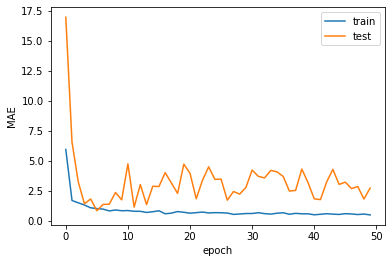

In [ ]:
plot_performance(history);

In [ ]:
print("maximum train option price :" , y_train.max())
print("mean train option price : " , np.mean(y_train))

maximum train option price : 22.31332673094635
mean train option price :  3.233704944639957


We notice that compared to the values of the dataset the MEA for the training data is pretty low for this simple regression model .

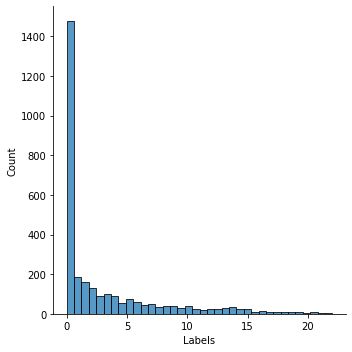

In [ ]:
#Plot test labels distribution
sns.displot(y_test)

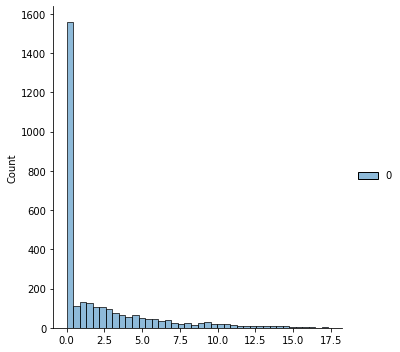

In [ ]:
#Plot prediction distribution
sns.displot(predictions)

# Compare prices to a traditional numerical solver such as Monte-Carlo, Finite Difference or any other methodology you may deem applicable.

In this part we will be using Monte Carlo for computing Basket option price.
we will be working on testing set . So we will load the test set that we saved earlier.

**Methodology:**

For making using of the MC simulations I used a function defined in this notebook  that uses MC for a call option : https://github.com/shrentseng/Numerical-methods-for-option-pricing/blob/main/Monte%20Carlo%20simulation%20option%20pricing.ipynb 
But as I am dealing with a Basket so when computing the payoff I need to pay attention to the weights.

In [ ]:
import os
if os.path.exists("test.csv"):
  print("Downloading test csv file .......") 
  test = pd.read_csv("test.csv")

In [ ]:
test.head()

,S/K,Maturity,Volatility,Rate,Labels,Prices,Strikes,Weight_0,Weight_1,Weight_2
0,0.500403,1.049777,0.307407,0.045450,0.325331,100.947789,201.732918,0.247177,0.429608,0.323215
1,0.505162,0.931086,0.229150,0.051873,0.018109,99.815417,197.591007,0.404801,0.579820,0.015379
2,0.503914,0.633329,0.821468,0.050701,7.309358,99.989959,198.426579,0.376317,0.388713,0.234969
3,0.508093,0.229480,0.896514,0.088480,1.620571,100.829961,198.447801,0.483914,0.063798,0.452288
4,0.495808,0.365142,0.472774,0.033222,0.103645,99.172107,200.021116,0.173385,0.175158,0.651458


In [ ]:
#Define a Monte carlo MC price empty list 
%time 
start = time.time()
mc_prices = []
for i in range(test.shape[0]):
    basket = BasketOption(
        test.iloc[i,7:].to_numpy(),
        test.iloc[i].Prices,
        test.iloc[i].Volatility,
        CORR,
        test.iloc[i].Strikes,
        test.iloc[i].Maturity,
        test.iloc[i].Rate
    )
    mc_prices.append(basket.get_mc())
end = time.time()
print(f"Runtime of MC is : .... {end - start}")    

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
Runtime of MC is : .... 9.853245735168457


# Compare to the case of 1 asset

In the case of 1 asset the correlation matrix takes one value :

So we will have same work as before with :

- corr = np.array([[1,]]) 
- n_assets = 1


In [ ]:
len(test)

3000

Summary :

The Main Goal of the client is explore novel methodologies for accelerating the pricing of exotic derivatives. The Client cares a lot about the time that an algorithm consumes to compute Option Price 

From  our experiment : with 10 000 data points and with 3000 data points on the test set the Neural network model needs  0.12 seconds to run and the MC algorithm needs 9.85 seconds to run.

